Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import os
import json

Device Configuration

In [2]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


Data Prep

In [3]:
# Download and load the CIFAR-100 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR100(root='../data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR100(root='../data', train=False, download=True, transform=transform)

# Split train data into train and validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

100.0%


Extracting ../data\cifar-100-python.tar.gz to ../data
Files already downloaded and verified


Set Random Seed

In [4]:
# Function to set a random seed for reproducibility
def set_seed(seed=None):
    if seed is None:
        seed = np.random.randint(0, 10000)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

Validation

In [5]:
# Function for validation
def validate(net, val_loader, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

Calculate Test Error

In [6]:
# Function to calculate test error
def calculate_test_error(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return 100 - test_accuracy  # Test error

Train Model

In [7]:
# Function for training
def train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    test_errors = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        val_loss = validate(net, val_loader, criterion)
        val_losses.append(val_loss)
        test_error = calculate_test_error(net, test_loader)
        test_errors.append(test_error)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Test Error: {test_errors[-1]}')

    return train_losses, val_losses, test_errors

Metrics Calculation

In [8]:
# Function to calculate accuracy, F1 score, and recall
def calculate_metrics(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, recall

Model Architecture

In [9]:
# ResNet-18 with SE block

# SE block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


def initialize_model(device):
    net = models.resnet18(weights=None)
    num_features = net.fc.in_features

    # Adding an SE block
    net.avgpool = nn.Sequential(net.avgpool, SEBlock(num_features))

    # Adjusting for 100 classes in CIFAR-100
    net.fc = torch.nn.Linear(num_features, 100)
    net = net.to(device)

    return net

Loss Function

In [10]:
def initialize_loss_function():
    return nn.CrossEntropyLoss()

Optimizer

In [11]:
import swats

def initialize_optimizer(model_params):
    return swats.SWATS(model_params)

Run

Run: 1
Seed: 9136


c:\Users\sbp5911\AppData\Local\Programs\Python\Python311\Lib\site-packages\swats\optim.py:126: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1519.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch 1/200, Train Loss: 3.7224940419197083, Validation Loss: 3.355609631538391, Test Error: 82.4
Epoch 2/200, Train Loss: 4.310154497623444, Validation Loss: 4.222249555587768, Test Error: 92.79
Epoch 3/200, Train Loss: 3.729277116060257, Validation Loss: 3.5875293254852294, Test Error: 84.58
Epoch 4/200, Train Loss: 3.346936410665512, Validation Loss: 3.3645572423934937, Test Error: 80.6
Epoch 5/200, Train Loss: 3.1359146773815154, Validation Loss: 3.2245511531829836, Test Error: 77.78
Epoch 6/200, Train Loss: 2.9659247398376465, Validation Loss: 3.310738468170166, Test Error: 78.76
Epoch 7/200, Train Loss: 2.8201122164726256, Validation Loss: 3.0750522136688234, Test Error: 74.86
Epoch 8/200, Train Loss: 2.6464925408363342, Validation Loss: 2.932746648788452, Test Error: 72.05
Epoch 9/200, Train Loss: 2.489531683921814, Validation Loss: 3.0610835790634154, Test Error: 72.95
Epoch 10/200, Train Loss: 2.3660829961299896, Validation Loss: 2.8859752893447874, Test Error: 69.25
Epoch 11/

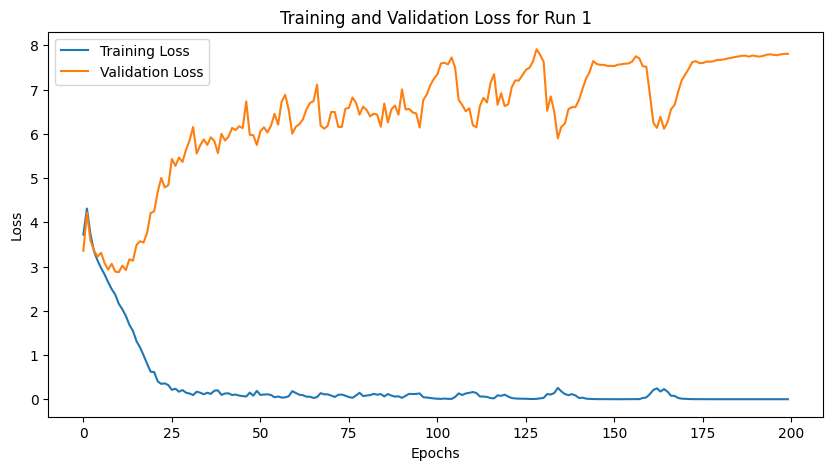

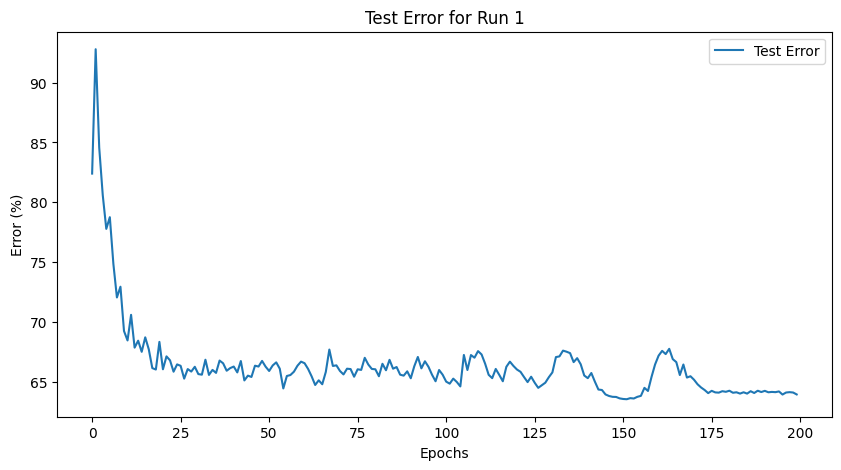

Run: 2
Seed: 2931
Epoch 1/200, Train Loss: 3.7070314645767213, Validation Loss: 3.3792137622833254, Test Error: 82.88
Epoch 2/200, Train Loss: 4.186936527490616, Validation Loss: 3.903631567955017, Test Error: 90.47
Epoch 3/200, Train Loss: 3.5515747725963593, Validation Loss: 3.431703305244446, Test Error: 82.24
Epoch 4/200, Train Loss: 3.228270959854126, Validation Loss: 3.302536201477051, Test Error: 78.73
Epoch 5/200, Train Loss: 3.019838869571686, Validation Loss: 3.183052182197571, Test Error: 77.82
Epoch 6/200, Train Loss: 2.835829955339432, Validation Loss: 3.007443833351135, Test Error: 73.5
Epoch 7/200, Train Loss: 2.6795768976211547, Validation Loss: 2.9456177949905396, Test Error: 72.03
Epoch 8/200, Train Loss: 2.5069192230701445, Validation Loss: 3.0157129526138307, Test Error: 72.66
Epoch 9/200, Train Loss: 2.3720811307430267, Validation Loss: 3.0155213832855225, Test Error: 71.92
Epoch 10/200, Train Loss: 2.2331125915050505, Validation Loss: 2.862058663368225, Test Error

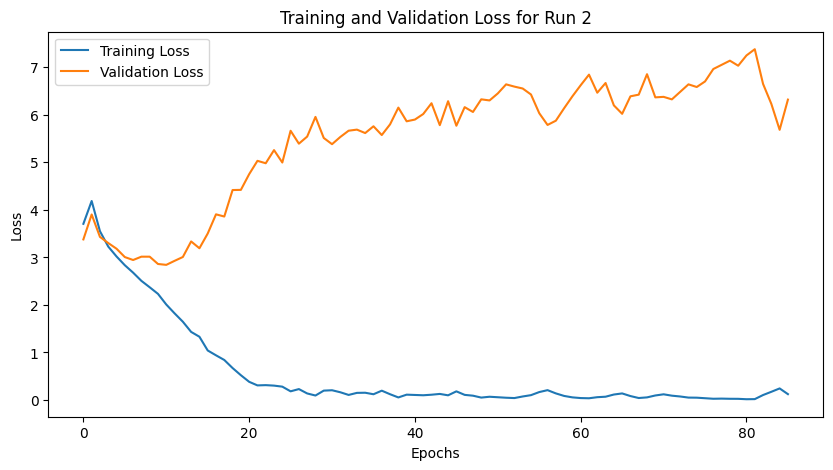

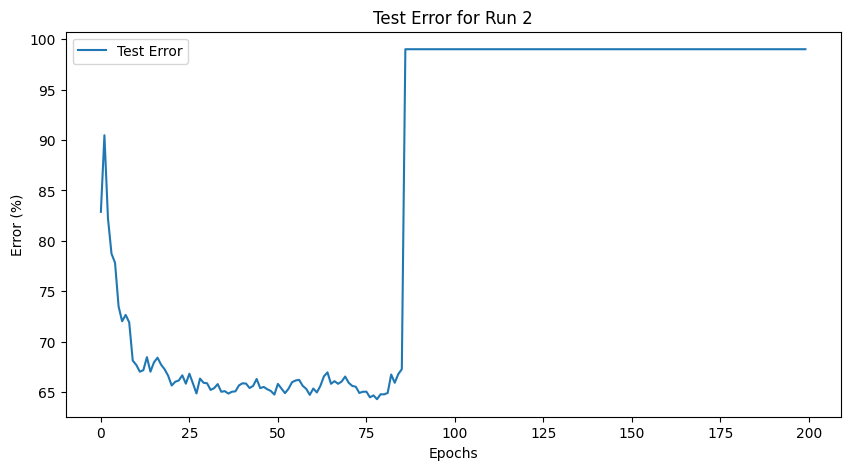

Run: 3
Seed: 726
Epoch 1/200, Train Loss: 3.731022071838379, Validation Loss: 3.357751417160034, Test Error: 81.89
Epoch 2/200, Train Loss: 4.072870057821274, Validation Loss: 3.7750810623168944, Test Error: 87.51
Epoch 3/200, Train Loss: 3.4328416287899017, Validation Loss: 3.457078552246094, Test Error: 82.31
Epoch 4/200, Train Loss: 3.172217643260956, Validation Loss: 3.318560838699341, Test Error: 79.85
Epoch 5/200, Train Loss: 2.973514324426651, Validation Loss: 3.179205298423767, Test Error: 76.72
Epoch 6/200, Train Loss: 2.7894077777862547, Validation Loss: 3.1108450174331663, Test Error: 75.14
Epoch 7/200, Train Loss: 2.6063557505607604, Validation Loss: 3.1414379835128785, Test Error: 73.62
Epoch 8/200, Train Loss: 2.443441042304039, Validation Loss: 2.9531540155410765, Test Error: 71.03
Epoch 9/200, Train Loss: 2.262367272377014, Validation Loss: 2.938777804374695, Test Error: 69.44
Epoch 10/200, Train Loss: 2.1011807531118394, Validation Loss: 2.8821876287460326, Test Error:

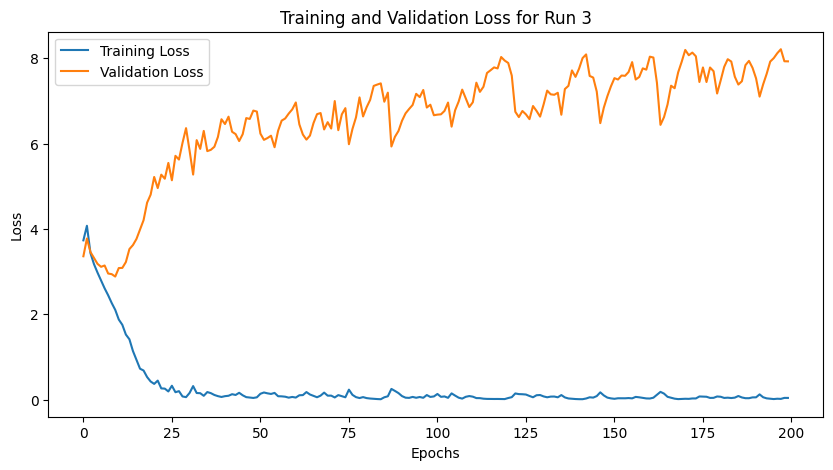

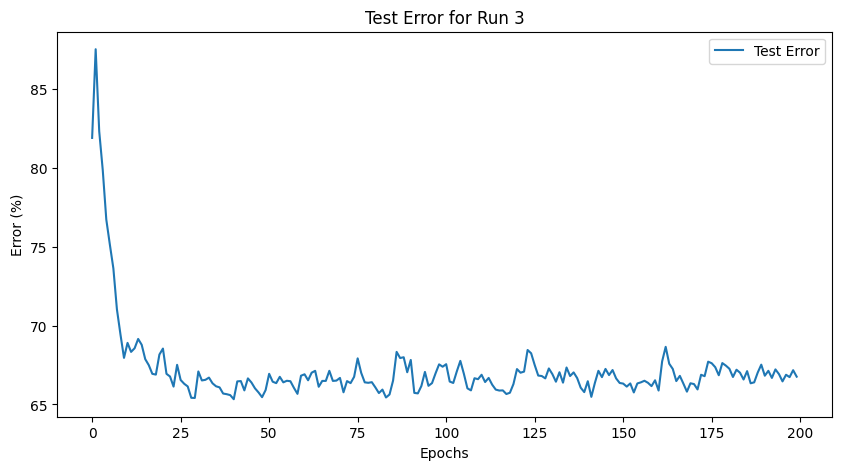

Run: 4
Seed: 2182
Epoch 1/200, Train Loss: 3.711227011680603, Validation Loss: 3.3603918075561525, Test Error: 82.52
Epoch 2/200, Train Loss: 4.207042634487152, Validation Loss: 3.884344148635864, Test Error: 90.44
Epoch 3/200, Train Loss: 3.6199633121490478, Validation Loss: 3.58549108505249, Test Error: 83.96000000000001
Epoch 4/200, Train Loss: 3.3022536873817443, Validation Loss: 3.3882781982421877, Test Error: 81.83
Epoch 5/200, Train Loss: 3.0957197904586793, Validation Loss: 3.3036885261535645, Test Error: 79.82
Epoch 6/200, Train Loss: 2.934403473138809, Validation Loss: 3.124418592453003, Test Error: 76.08
Epoch 7/200, Train Loss: 2.743509829044342, Validation Loss: 2.9386059045791626, Test Error: 71.91
Epoch 8/200, Train Loss: 2.573073387145996, Validation Loss: 2.861987042427063, Test Error: 70.28999999999999
Epoch 9/200, Train Loss: 2.434545856714249, Validation Loss: 2.99924259185791, Test Error: 72.38
Epoch 10/200, Train Loss: 2.292818212509155, Validation Loss: 2.8834942

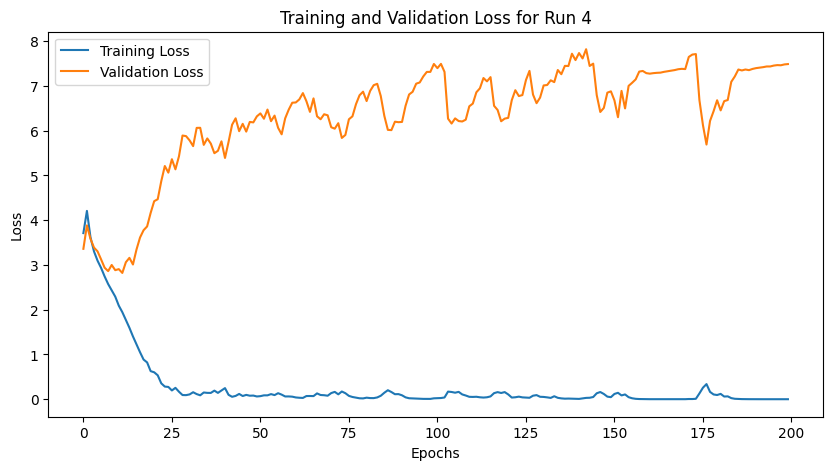

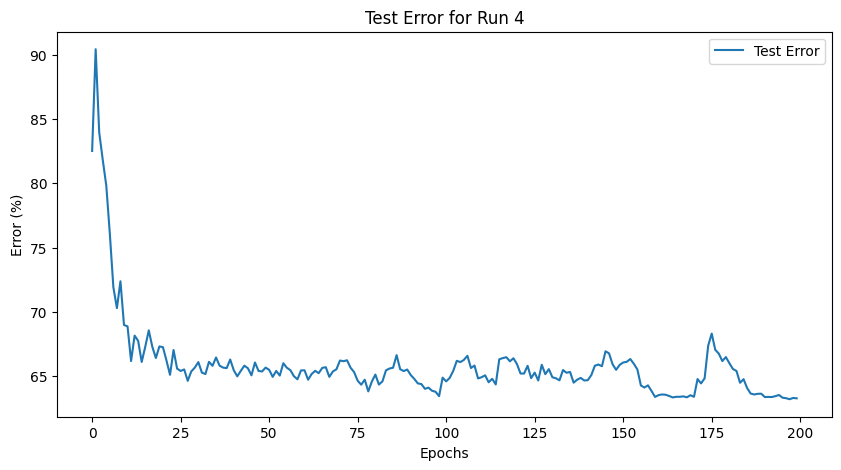

Run: 5
Seed: 3857
Epoch 1/200, Train Loss: 3.7178897321224214, Validation Loss: 3.417661929130554, Test Error: 82.82
Epoch 2/200, Train Loss: 4.243028396368027, Validation Loss: 3.7725733041763307, Test Error: 88.25
Epoch 3/200, Train Loss: 3.5726252257823945, Validation Loss: 3.665545177459717, Test Error: 85.49
Epoch 4/200, Train Loss: 3.304004567861557, Validation Loss: 3.5010907649993896, Test Error: 82.81
Epoch 5/200, Train Loss: 3.116945469379425, Validation Loss: 3.2109981298446657, Test Error: 77.36
Epoch 6/200, Train Loss: 2.898627209663391, Validation Loss: 3.0897480964660646, Test Error: 74.87
Epoch 7/200, Train Loss: 2.7440842151641847, Validation Loss: 2.9711320400238037, Test Error: 72.52
Epoch 8/200, Train Loss: 2.5811243772506716, Validation Loss: 3.2353169918060303, Test Error: 74.56
Epoch 9/200, Train Loss: 2.4574560940265657, Validation Loss: 2.930620050430298, Test Error: 70.36
Epoch 10/200, Train Loss: 2.242793917655945, Validation Loss: 2.9362347602844237, Test Er

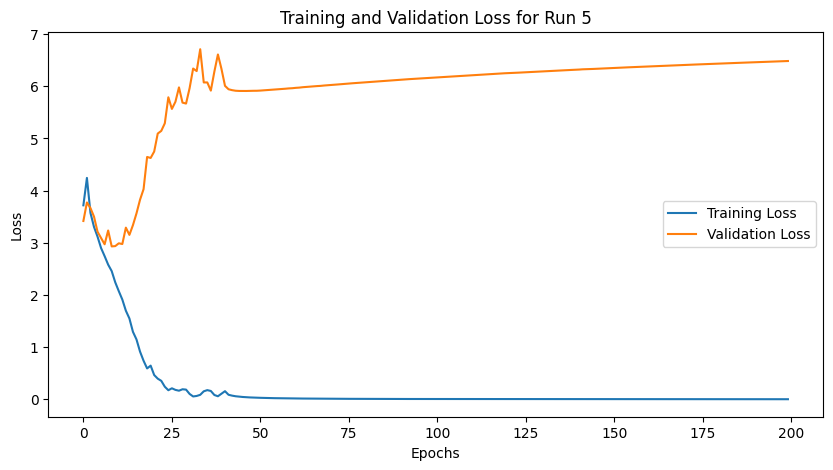

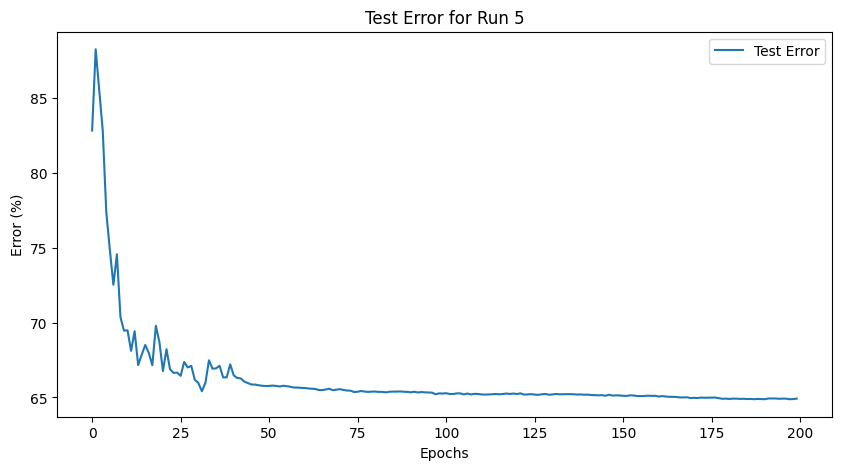

In [12]:
# Run the training for 5 different seeds
num_runs = 5
epochs = 200
metrics = {
    'seed': [],
    'train_losses': [],
    'val_losses': [],
    'test_errors': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_recall': [],
    'test_accuracy': [],
    'test_f1': [],
    'test_recall': []
}



# Initialize dictionaries to store results
results = {
    'train_losses': [],
    'val_losses': [],
    'test_errors': []
}

for run in range(num_runs):
    print(f"Run: {run + 1}")
    seed = set_seed()
    print(f"Seed: {seed}")

    # Reinitialize the model, loss function, and optimizer
    net = initialize_model(device=device)
    criterion = initialize_loss_function()
    optimizer = initialize_optimizer(model_params=net.parameters())

    # Train the network
    train_losses, val_losses, test_errors = train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs)
    metrics['test_errors'].append(test_errors)

    # Calculate metrics on validation and test sets
    val_accuracy, val_f1, val_recall = calculate_metrics(net, val_loader)
    test_accuracy, test_f1, test_recall = calculate_metrics(net, test_loader)
    
    # Print metrics for validation set
    print(f"Run {run + 1} - Validation Metrics:")
    print(f"    Accuracy: {val_accuracy}%")
    print(f"    F1 Score: {val_f1}")
    print(f"    Recall:   {val_recall}")

    # Print metrics for test set
    print(f"Run {run + 1} - Test Metrics:")
    print(f"    Accuracy: {test_accuracy}%")
    print(f"    F1 Score: {test_f1}")
    print(f"    Recall:   {test_recall}")
    
    # Store metrics
    metrics['seed'].append(seed)
    metrics['train_losses'].append(train_losses)
    metrics['val_losses'].append(val_losses)
    metrics['val_accuracy'].append(val_accuracy)
    metrics['val_f1'].append(val_f1)
    metrics['val_recall'].append(val_recall)
    metrics['test_accuracy'].append(test_accuracy)
    metrics['test_f1'].append(test_f1)
    metrics['test_recall'].append(test_recall)
    
    # Append the results for the current run
    results['train_losses'].append(metrics['train_losses'][run])
    results['val_losses'].append(metrics['val_losses'][run])
    results['test_errors'].append(metrics['test_errors'][run])

    # Plot for training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_losses'][run], label='Training Loss')
    plt.plot(metrics['val_losses'][run], label='Validation Loss')
    plt.title(f"Training and Validation Loss for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot for test error
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['test_errors'][run], label='Test Error')
    plt.title(f"Test Error for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.show()

Metrics Calculation and Plotting Mean Test Error

Mean Metrics: {'val_accuracy': 27.109999999999996, 'val_f1': 0.26727082957367165, 'val_recall': 0.2711, 'test_accuracy': 28.419999999999995, 'test_f1': 0.2801310378820284, 'test_recall': 0.2842}
Standard Deviation of Metrics: {'val_accuracy': 13.067478716263517, 'val_f1': 0.13393762249341962, 'val_recall': 0.13067478716263517, 'test_accuracy': 13.760213661131864, 'test_f1': 0.1405073525163099, 'test_recall': 0.13760213661131865}


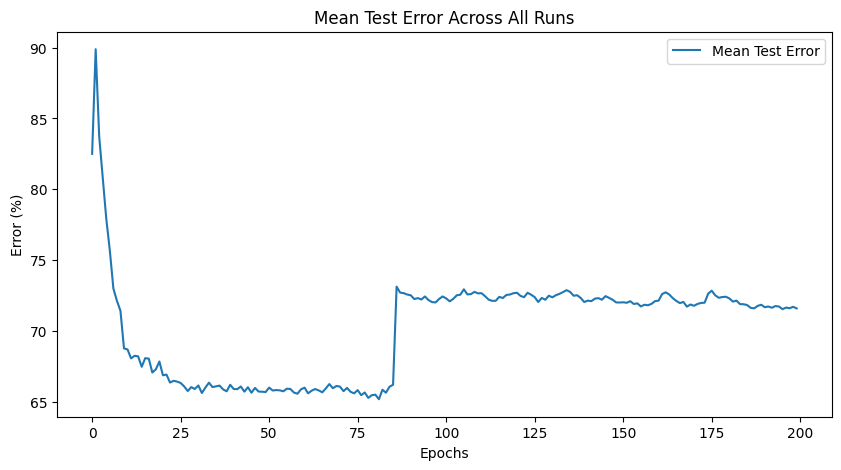

In [13]:
# Calculate mean and standard deviation across runs
mean_metrics = {metric: np.mean(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}
std_metrics = {metric: np.std(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}

# Print mean metrics and standard deviation
print("Mean Metrics:", mean_metrics)
print("Standard Deviation of Metrics:", std_metrics)

# Calculate mean test error across all runs
mean_test_errors = np.mean(metrics['test_errors'], axis=0)

# Plot mean test error
plt.figure(figsize=(10, 5))
plt.plot(mean_test_errors, label='Mean Test Error')
plt.title("Mean Test Error Across All Runs")
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

Save data

In [14]:
# Directory for saving results
save_dir = 'CIFAR_100_RN18_AL_Results'
os.makedirs(save_dir, exist_ok=True)

# Save the results to a file
with open(os.path.join(save_dir, 'SWATS.json'), 'w') as f:
    json.dump(results, f)